# Spambase


In [ ]:
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import pandas            as pd

from matplotlib              import gridspec

from tqdm.notebook           import tqdm

from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.model_selection import ParameterGrid
from sklearn.svm             import SVC, SVR

from mlxtend.plotting        import plot_decision_regions


Установим дополнительный пакет для удобного импорта [датасета](https://archive.ics.uci.edu/dataset/94/spambase).

In [ ]:

!pip install ucimlrepo

#Анализ выборки

## Загрузка датасета

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
spambase = fetch_ucirepo(id=94)

dataset = pd.DataFrame(spambase['data']['features'])
dataset['target'] = spambase['data']['targets']

dataset.sample(5, random_state=0)

# metadata
#print(spambase.metadata)

# variables
#print(spambase.variables)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
991,0.1,0.20,1.01,0.0,0.80,0.80,0.5,0.00,0.8,0.10,...,0.000,0.111,0.000,0.491,0.158,0.015,8.550,669,1351,1
2565,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.000,0.552,0.000,0.000,0.000,0.000,1.000,1,4,0
1906,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.666,4,15,0
1471,0.0,0.82,0.32,0.0,1.14,0.32,0.0,0.16,0.0,0.65,...,0.000,0.000,0.000,0.000,0.290,0.029,2.257,13,158,1
1813,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,...,0.022,0.022,0.019,0.022,0.022,0.022,3.482,5,5902,0


In [ ]:
print("Имя датасета: {}".format(spambase.metadata.name))
print("Задача: {}".format(spambase.metadata.abstract))
print("Количество признаков: {}".format(spambase.metadata.num_features))
print("Количество объектов выборки: {}".format(spambase.metadata.num_instances))

Имя датасета: Spambase
Задача: Classifying Email as Spam or Non-Spam
Количество признаков: 57
Количество объектов выборки: 4601


Большинство признаков описывают частоту встречаемости того или иного символа и слова. Остальные три признака (55-57) описывают длину последовательности подряд идущих заглавных букв.

Требуется определить является ли письмо спамом (1) или нет (0).

## Визуализация данных

Для первичного анализа из всех признаков выберем 3 последних, так как они сильно отличаются от большинства, а также возьмём первые 2 признака, чтобы посмотреть хотя бы для них: есть ли явные зависимости.

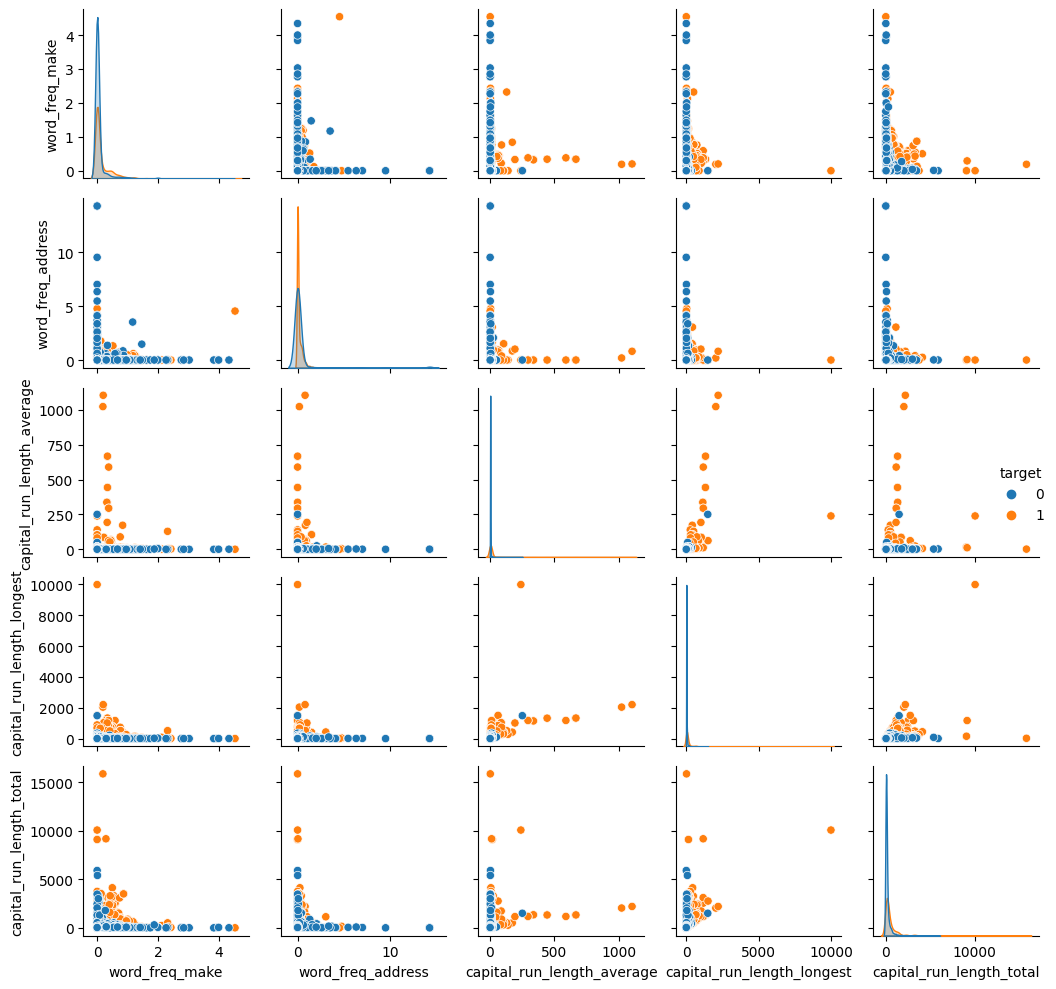

In [ ]:
features = list(dataset.columns)[:2] + list(dataset.columns)[-4:]

sns.pairplot(dataset[features], hue='target', height=2)
plt.tight_layout()
plt.show()

Из графиков геометрически два класса не разделяются, но можно выделить следующие тренды:


1.   Не спам-сообщения имеют меньшую среднюю длину последовательности подряд идущих заглавных букв.
2.   Не спам сообщения имеют меньшую наибольшую длину последовательности подряд идущих заглавных букв.



# Препроцессинг данных

Все признаки лежат в поле действительных чисел.

# Нормировка признаков

In [ ]:
scaler = MaxAbsScaler()

features = list(dataset.columns)[:-1]

scaler.fit(dataset[features])

dataset[features] = scaler.transform(dataset[features])

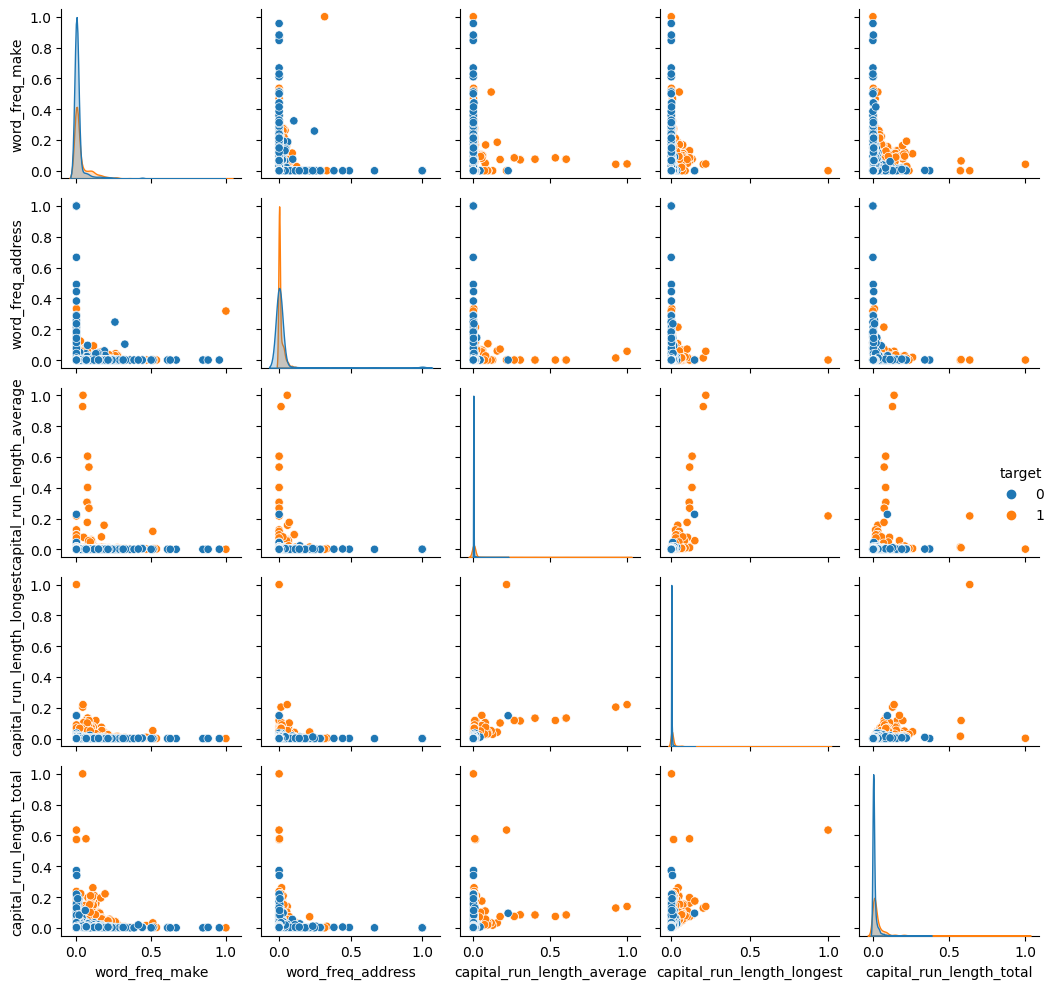

In [ ]:
features = list(dataset.columns)[:2] + list(dataset.columns)[-4:]

sns.pairplot(dataset[features], hue='target', height=2)
plt.tight_layout()
plt.show()

# Эксперимент

Рассматриваемые методы: Метод Парзеновского окна, SVM, Логистическая регрессия

In [ ]:
X = dataset.iloc[:, dataset.columns != 'target'].values
Y = dataset.iloc[:, dataset.columns == 'target'].values.reshape(-1)
Y = np.array(Y, dtype=np.int64)

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=1000, random_state=0)

# Метод Парзеновского окна

In [ ]:
def E(distance, h = 0.05):
    ret = np.array(distance) / h
    return (1 - ret**2) * (np.abs(ret) <= 1)

def Q(distance, h = 0.05):
    ret = np.array(distance) / h
    return (1 - ret**2)**2 * (np.abs(ret) <= 1)

def G(distance, h = 0.05):
  ret = np.array(distance)/h
  return np.exp(-2 * ret**2)

Подберём гиперпараметры (ядро и размер окна) с помощью кросс-валидацию.

In [ ]:
kf = KFold(10, shuffle = True, random_state = 0)
number_of_batch = kf.get_n_splits(X_train)

scores = {}

grid = ParameterGrid({'K': [E, Q, G],
                      'h': [0.03, 0.05, 0.1, 0.2, 0.3]})

for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(kf.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = KNeighborsClassifier(n_neighbors = len(x_train),
                                     weights = lambda x:
                                     item['K'](x, h=item['h']))
        _ = model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    scores[item['K'], item['h']] = np.mean(list_of_scores)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Теперь по полученным гиперпараметрам, оценим наилучшую точность на тестовой выборке.

In [ ]:
sorted_scores = sorted(scores.items(), reverse = True,
                        key = lambda x: x[1])

# print(sorted_scores)

best_K, best_h = sorted_scores[0][0][0], sorted_scores[0][0][1]

model = KNeighborsClassifier(n_neighbors=len(X_train),
                             weights=lambda x: best_K(x, h = best_h))
_ = model.fit(X_train, Y_train)

print('Ядро: {} h: {}'.format(best_K, best_h))
print('Точность: {:.3f}'.format(model.score(X_test, Y_test)))
print(classification_report(model.predict(X_test), Y_test))

Ядро: <function G at 0x7b8f6f5d9630> h: 0.05
Точность: 0.903
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       604
           1       0.86      0.90      0.88       396

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



# SVM

Подберем гиперпараметры (параметр регуляризации, ядро и его параметр) с помощью кросс-валидации.

In [ ]:
kf = KFold(10, shuffle = True, random_state = 0)
number_of_batch = kf.get_n_splits(X_train)

scores = {}

grid = ParameterGrid({'C': [1e-4, 1e-3, 1e-2, .1,],
                      'kernal': ['linear', 'poly', 'rbf'],
                      'gamma': [0.03, 0.05, 0.1, 0.2]})

for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(kf.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = SVC(C = 2 / item['C'], kernel = item['kernal'],
                    gamma = item['gamma'])

        _ = model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    scores[item['kernal'], item['C'], item['gamma']] = np.mean(list_of_scores)


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
sorted_scores = sorted(scores.items(), reverse = True,
                        key = lambda x: x[1])

# print(sorted_scores)

best_K     = sorted_scores[0][0][0]
best_C     = sorted_scores[0][0][1]
best_gamma = sorted_scores[0][0][2]


model = SVC(C = 2 / best_C, kernel = best_K, gamma = best_gamma)
_ = model.fit(X_train, Y_train)

print('Ядро: {} gamma: {} C: {}'.format(best_K, best_gamma, best_C))
print('Точность: {:.3f}'.format(model.score(X_test, Y_test)))
print(classification_report(model.predict(X_test), Y_test))

Ядро: rbf gamma: 0.05 C: 0.0001
Точность: 0.937
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       604
           1       0.90      0.94      0.92       396

    accuracy                           0.94      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.94      0.94      0.94      1000



In [ ]:
print('Количество опорных векторов из класса 0: {}/{}'.format(
      len([item for item in Y_train[model.support_] if item == 0]),
      len([item for item in Y_train                 if item == 0])))

print('Количество опорных векторов из класса 1: {}/{}'.format(
      len([item for item in Y_train[model.support_] if item != 0]),
      len([item for item in Y_train                 if item != 0])))

Количество опорных векторов из класса 0: 307/2201
Количество опорных векторов из класса 1: 316/1400


# Логистическая регрессия

Подберем гиперпараметры (регуляризатор и его параметр) с помощью кросс-валидации.

In [ ]:
kf = KFold(10, shuffle = True, random_state = 0)
number_of_batch = kf.get_n_splits(X_train)

scores = {}

grid = ParameterGrid({'penalties': ['l1', 'l2'],
                      'C': [1e-5, 1e-4, 1e-3, 1e-2, .1,
                            1., 10., 1e2, 1e3, 1e4, 1e5]})

for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(kf.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        # fit_intercept = True, because graph is not being plotted
        model = LogisticRegression(penalty = item['penalties'],
                                   C = 2 / item['C'], solver='liblinear',
                                   random_state = 0, max_iter = 1000)
        _ = model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    scores[item['penalties'], item['C']] = np.mean(list_of_scores)


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Теперь по полученным гиперпараметрам, оценим наилучшую точность на тестовой выборке.

In [ ]:
sorted_scores = sorted(scores.items(), reverse = True,
                        key = lambda x: x[1])

# print(sorted_scores)

best_penalty, best_gamma = sorted_scores[0][0][0], sorted_scores[0][0][1]

# fit_intercept = True, because graph is not being plotted
model = LogisticRegression(penalty = best_penalty, C = 2 / best_gamma,
                           solver='liblinear', random_state = 0,
                           max_iter = 1000)
_ = model.fit(X_train, Y_train)

print('Регуляризатор: {} С: {}'.format(best_penalty, best_gamma))
print('Точность: {:.3f}'.format(model.score(X_test, Y_test)))
print(classification_report(model.predict(X_test), Y_test))

Регуляризатор: l1 С: 0.1
Точность: 0.907
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       606
           1       0.86      0.91      0.88       394

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000



# Итоги

Для данного датасета были рассмотрены следующие методы: метод Парзеновского окна, SVM, логистическая регрессия.

1. Метод Парзеновского окна
> Для этого метода подбирались следующие гиперпараметры: ядро K и размер окна h. Наилучшие результаты получились с помощью ядра Гаусса G при размере окна h = 0.05. Точность при данных параметрах получилась 90.3%.

2. SVM
> Для этого метода подбирались следующие гиперпараметры: ядро kernal и его параметр, и параметр регуляризации. Наилучшие результаты получились с помощью ядра Гаусса G при его параметре gamma = 0.05, параметре регуляризации С = 1e-4. Точность при данных параметрах получилась 93.7%.

3. Логистическая регрессия
> Для этого метода подбирались следующие гиперпараметры: регуляризатор penalty и его параметр. Наилучшие результаты получились при l1 и C = 0.1. Точность при данных параметрах получилась 90.7%.

Итого:

*   Лучший результат дал метод SVM, но прокомментируем и остальные результаты.
*   В обоих случаях лучшим ядром оказалось ядро Гаусса.
*   При этом для опорных векторов, коэффициент регуляризации был слишком маленьким (знаменатель дроби), а значит в нашей выборке наблюдается мультиколлинеарность признаков. Многие точки лежат внутри выборки, так как опорными осталось только по 300 объектов из каждого класса, а было 2201 и 1407 соответственно из каждого класса.

Возникшие трудности:
* Тяжело анализировать графически многопризнаковые данные. Особенно с такой локальностью объектов (все объекты лежат локально, кроме нескольких, которые заведомо спамерские с аномалией в признаках). Использовались разные методы нормировки, но читаемость графиков лучше не получалась.
* plot_decision_regions - было решено не использовать, по первичному анализу было понятно, что на графике будет тяжело понять, как хорошо сработал метод.
* При таких маленьких коэффициентах регуляризации метод SVC сходится очень долго, но зато исключается мультиколлинеарность.

Результаты совпали с предпалагаемыми, SVM оказался наиболее эффективным методом из-за особенности выборки. Исключилась мультиколлинеарность признаков, которая очевидно была (много однотипных признаков).